# Matching Code

This code is to implement and test different matching methods

Explain why we did matching? plot average distances of matching. Think of a KPI. Illustrate with one graph or visualisation, this can be a good distance measure, then back up with literature, the ECB article.

Comapre the coverage, do we have more bonds than taking a very strict matching algorithm, Create a table with different matching algorithms and the results. Show that we used different matching methods.

emphasise that the data is scarce, we do not want to lose too much data, get better results with broader scope. 

for any given green bond, take the match which has the smallest distance
take average distance. group by bonds and conventional bond unique name, compute mean average distance.
then take smallest pair in average.

weight the coupon in the distance measure a bit less, put more weight on the days to maturity.
include emission date measure. 

Show this in our analysis.

test YTM vs. Z-spread.

• Aggregate bonds by ISIN per company (since each bond appears over multiple dates) so that matching is done at the bond‐level rather than per DateTime row.
• Compute a custom distance using three features (Coupon, days‐to‐maturity, and an emission year extracted from your emission columns). We then down‐weight Coupon (here by a factor of 0.5) so that differences in days‐to‐maturity and emission year matter more.
• Perform one‐to‐one matching by solving a bipartite assignment (using the Hungarian algorithm via SciPy’s linear_sum_assignment) so that each green bond is matched with one conventional bond (and vice‐versa as far as possible).
• After matching, we merge the matched bond pairs back with the original time‐series data (using DateTime) to compute the YTM difference (green minus conventional) on the dates where both bonds are observed.
• Finally, we run a regression of the YTM difference on the matching “distance” as an example. (You could, of course, include additional controls or test against the Z‑spread if available.)
• A bar chart is produced as a key performance indicator (KPI) visualization of average matching distance per company. This type of plot can serve as a “good distance measure” and can be compared with similar measures in the literature (for example, see the ECB article on matching methods).

Why Matching?
 Matching green bonds with conventional ones allows us to form comparable pairs so that differences in yield‐to‐maturity (YTM) can be more reliably attributed to “green” factors rather than differences in bond characteristics. A good distance measure (here the Euclidean distance between standardized features) helps ensure that the matched pairs are similar. Researchers (see, for example, ECB publications) have used similar approaches to control for confounding variables.

Visualization (KPI):
 The bar chart of average matching distance per company provides an intuitive measure of how “close” the pairs are. A lower average distance indicates better matches. This can be used as a key performance indicator when comparing different matching methods.

Coverage vs. Stringency:
 By comparing the number of matches and average distances across methods (as illustrated in the optional summary table), one can demonstrate that while stricter matching may yield a lower average distance (better quality), it might also lead to a smaller sample. In our context—where data are scarce—a broader matching criterion (one-to-one matching as shown) may be preferable.

Regression Analysis:
 After matching, the code merges the time series data so that for each bond pair we have YTM observations over time. The regression of the YTM difference on the matching distance (and any other covariates you may add) tests whether the “quality” of the match relates to the observed YTM spread. You could extend this analysis to test against the Z‑spread as well.

Stacked Panel Regression:
The new function prepare_stacked_regression_data creates a dataset where each time-series observation from the green and conventional bonds is kept (with an indicator is_green and other characteristics such as Coupon and maturity). We then run a panel regression (using clustered standard errors by bond pair) to see if, after controlling for these factors, there is a significant difference in YTM between green and conventional bonds.

# Cleaned Code

## 1 - Imports

In [8]:
# Import with correcting the dataset parsing
import pandas as pd
import numpy as np

def parse_numeric(value):
    """
    Convert a string like '3,08%', '3.08', '3,08', '3.1%' to a float.
    Removes trailing '%' if present, replaces commas with dots,
    and attempts float conversion. Returns NaN on failure.
    """
    if pd.isna(value):
        return np.nan
    # Convert to string in case it is not
    value_str = str(value).strip()
    # Remove percentage sign if present
    value_str = value_str.replace('%', '')
    # Replace commas with dots
    value_str = value_str.replace(',', '.')
    # Attempt to convert to float
    try:
        return float(value_str)
    except ValueError:
        return np.nan

# Read your CSV file
url = "https://raw.githubusercontent.com/Fijiman001/EGR-Empirical-Project/refs/heads/main/data/Final%20data%20for%20the%20study/df_final_7.csv"
df = pd.read_csv(url)

# Now parse the columns of interest. For example, if you have columns:
# 'YTM', 'Coupon', 'Modified Duration', etc.
df['YTM'] = df['YTM'].apply(parse_numeric)
df['Coupon'] = df['Coupon'].apply(parse_numeric)
df['Modified Duration'] = df['Modified Duration'].apply(parse_numeric) / 1000

# Now df['YTM'], df['Coupon'], and df['Modified Duration'] will be numeric.
print(df[['YTM','Coupon','Modified Duration']].head(10))

    YTM  Coupon  Modified Duration
0  2.46   0.375              2.405
1  2.50   0.375              2.405
2  2.47   0.375              2.405
3  2.51   0.375              2.405
4  2.55   0.375              2.405
5  2.52   0.375              2.405
6  2.57   0.375              2.405
7  2.53   0.375              2.405
8  2.52   0.375              2.405
9  2.55   0.375              2.405


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional: Configure matplotlib for inline plotting
%matplotlib inline

In [10]:
print(df.columns)

# The amount of companies with more than 1 unique ISIN
companies = df.groupby('Company')['ISIN'].nunique()
companies = companies[companies > 1]
print(companies)

# Companies with both 1 green and one conventional bond, 'is_green needs to be both 0 and 1
companies = df.groupby('Company')['is_green'].nunique()
companies = companies[companies == 2]
print(companies)

# of those companies, we look at the amount of bonds available
matching_companies = {}
for company in companies.index:
    group = df[df['Company'] == company]
    matched = group['ISIN'].nunique()
    print(f"{company}: {matched} unique ISINs")
    matching_companies[company] = matched
print("list of issuers with both green and conventional bonds we will be analysing")
print(list(matching_companies.keys()))

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')
Company
a2a s p a                                3
ab svensk exportkredit                   2
acea s p a                               2
amprion gmbh                     

we keep firms that have both a green and conventional bond in the data set, we will be using those to create a subset of the data that we will be using to run our analysis on

In [11]:
df_for_matching = df[df['Company'].isin(matching_companies.keys())]
# Dimensions of df_for_matching, the amount of unique ISINs, and the amount of Companies
print(df_for_matching.shape)
print(df_for_matching['ISIN'].nunique())
print(df_for_matching['Company'].nunique())
# amount of bonds that are green
print(df_for_matching[df_for_matching['is_green'] == 1]['ISIN'].nunique())

(6588, 44)
288
35
100


the matched data set only has 6588 rows, with 288 unique ISINS and 35 unique emitters. of those 288 bonds, 100 bonds are green
given this subset of data, we create our distance measure to find the closest comparable bonds to the green bonds

In [12]:
# Overview of the currencies used in the dataset
df_for_matching['Emissionswährung'].unique()
for currency in df_for_matching['Emissionswährung'].unique():
    print(currency)
    print(df[df['Emissionswährung'] == currency]['ISIN'].nunique())

EUR
370
USD
27
CAD
3
BRL
2
COP
1
GBP
5
NZD
1
NOK
1
HUF
1
ZAR
1
AUD
2
TRY
1


we will only keep EUR bonds

In [13]:
# keeping only EUR
df_for_matching = df_for_matching[df_for_matching['Emissionswährung'] == 'EUR']
print(df_for_matching.shape)

(5948, 44)


In [14]:
print(df_for_matching.columns)
print(df_for_matching.head())

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')
                   Name Clean_Company_Maturity     WKN  \
0  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   
1  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR

## 2 - Matching Functions
One-to-One Matching

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

def get_emission_year(row, emission_cols):
    """
    Extract the emission year from the indicator columns.
    Assumes exactly one of the 'Emission_year_' columns is True.
    """
    for col in emission_cols:
        if row[col]:
            # Remove potential trailing '.0' and convert to integer
            return int(col.split('_')[-1].split('.')[0])
    return np.nan

def match_green_bonds_one_to_one_all_obs_with_time(df, time_weight=1.0):
    """
    For each company, perform one-to-one matching between green and conventional bond observations
    using all available time series data. In addition to the original matching features (Coupon,
    days_to_maturity, emission_year), this function includes a time feature derived from DateTime.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with bond data containing at least the following columns:
            'Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green', 'YTM',
        plus columns starting with 'Emission_year_' indicating the bond’s emission year.
    time_weight : float, default 1.0
        Weight to apply to the standardized time feature. Increase to put more emphasis on matching
        observations that are closer in time.
    """
    # Convert key columns to numeric
    df['YTM'] = pd.to_numeric(df['YTM'], errors='coerce')
    df['Coupon'] = pd.to_numeric(df['Coupon'], errors='coerce')
    df['days_to_maturity'] = pd.to_numeric(df['days_to_maturity'], errors='coerce')
    df['Modified Duration'] = pd.to_numeric(df['Modified Duration'], errors='coerce')
    df['Last Price'] = pd.to_numeric(df['Last Price'], errors='coerce')
    
    # Compute emission_year from columns that start with 'Emission_year_'
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df = df.copy()
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    # Convert DateTime to a numeric value.
    # Here we convert DateTime to days since epoch.
    df['Time'] = pd.to_datetime(df['DateTime']).astype(np.int64) / (1e9 * 3600 * 24)
    
    # Sort by DateTime to preserve the time series order
    df_sorted = df.sort_values('DateTime')
    
    matched_results = []
    
    for company in df_sorted['Company'].unique():
        comp_df = df_sorted[df_sorted['Company'] == company]
        if not (comp_df['is_green'].eq(1).any() and comp_df['is_green'].eq(0).any()):
            continue
        
        green_df = comp_df[comp_df['is_green'] == 1].reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].reset_index(drop=True)
        
        # Define features for matching (note that DateTime is now represented by "Time")
        features = ['Coupon', 'days_to_maturity', 'emission_year', 'Time']
        combined_features = comp_df[features]
        
        means = combined_features.mean()
        stds = combined_features.std()
        
        green_scaled = ((green_df[features] - means) / stds).reset_index(drop=True)
        conv_scaled = ((conv_df[features] - means) / stds).reset_index(drop=True)
        
        # Down-weight coupon differences to reduce their influence on matching
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        # Optionally adjust the time difference weight
        green_scaled['Time'] *= time_weight
        conv_scaled['Time'] *= time_weight
        
        # Compute the Euclidean distance matrix between green and conventional observations
        green_mat = green_scaled.values
        conv_mat = conv_scaled.values
        distance_matrix = np.sqrt(((green_mat[:, None, :] - conv_mat[None, :, :]) ** 2).sum(axis=2))
        
        # Solve the assignment problem using the Hungarian algorithm for one-to-one matching
        row_ind, col_ind = linear_sum_assignment(distance_matrix)
        
        for r, c in zip(row_ind, col_ind):
            green_obs = green_df.iloc[r]
            conv_obs = conv_df.iloc[c]
            matched_results.append({
                'Company': company,
                'Green_Bond_ISIN': green_obs['ISIN'],
                'Green_Bond_Name': green_obs.get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_obs['Coupon'],
                'Green_Bond_Maturity': green_obs['days_to_maturity'],
                'Green_Bond_Emission_Year': green_obs['emission_year'],
                'Green_Bond_YTM': green_obs['YTM'],
                'Green_Bond_Price': green_obs['Last Price'],
                'Green_Bond_Mdur': green_obs['Modified Duration'],
                'Green_Bond_DateTime': green_obs['DateTime'],
                'Conv_Bond_ISIN': conv_obs['ISIN'],
                'Conv_Bond_Name': conv_obs.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_obs['Coupon'],
                'Conv_Bond_Maturity': conv_obs['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_obs['emission_year'],
                'Conv_Bond_YTM': conv_obs['YTM'],
                'Conv_Bond_Price': conv_obs['Last Price'],
                'Conv_Bond_Mdur': conv_obs['Modified Duration'],
                'Conv_Bond_DateTime': conv_obs['DateTime'],
                'Matching_Distance': distance_matrix[r, c]
            })
    
    return pd.DataFrame(matched_results)

In [16]:
# Run the matching function on your prepared DataFrame (e.g., df_matched)
df_matched = match_green_bonds_one_to_one_all_obs_with_time(df_for_matching)

In [ ]:
# Create a new column for the YTM difference (green bond YTM minus conventional bond YTM)
df_matched['YTM_diff'] = df_matched['Green_Bond_YTM'] - df_greedy['Conv_Bond_YTM']
df_matched['Mdur_diff'] = df_matched['Green_Bond_Mdur'] - df_matched['Conv_Bond_Mdur']
df_matched['Coupon_diff'] = df_matched['Green_Bond_Coupon'] - df_matched['Conv_Bond_Coupon']
df_matched['days_to_maturity_diff'] = df_matched['Green_Bond_Maturity'] - df_matched['Conv_Bond_Maturity']
print(df_matched.head())
print(df_matched['YTM_diff'].describe())

  Company Green_Bond_ISIN      Green_Bond_Name  Green_Bond_Coupon  \
0  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
1  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
2  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
3  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   
4  rwe ag    xs2584685031  RWE AG 3,625% 23/29              3.625   

   Green_Bond_Maturity  Green_Bond_Emission_Year  Green_Bond_YTM  \
0                 1503                      2023            2.94   
1                 1503                      2023            2.96   
2                 1502                      2023            2.99   
3                 1502                      2023            3.01   
4                 1502                      2023            3.03   

   Green_Bond_Price  Green_Bond_Mdur   Green_Bond_DateTime  ...  \
0            102.67            3.362  2025-01-02T13:00:00Z  ...   
1            102.59            3.362  2025

Matching using a distance measure based upon coupon, seniority, difference between datetime, and emission year gives an average difference in yield of: $-0.170393$
Below we run a regression: we cluster the standard errors by issuer (using the "Company" variable) to account for the possibility that observations from the same issuer may have correlated error terms.

Clustering the errors by issuer (i.e. by the "Company" column) allows the regression to adjust for potential correlations in the error terms among observations coming from the same issuer. In our context, this means that if multiple matched pairs come from the same company, their errors might be correlated due to unobserved company-specific factors. Standard OLS assumes that errors are independent across all observations, so if this assumption is violated, standard errors (and therefore inference such as t-statistics and p-values) may be misleading.

By clustering on issuer, we let the model relax the independence assumption within each company group while still assuming independence across companies. This generally results in robust (and often larger) standard errors, leading to more reliable hypothesis tests regarding the effect of Matching_Distance on the yield difference.

In [18]:
# Looking at na values
df_matched[['Matching_Distance', 'Mdur_diff', 'Coupon_diff', 'days_to_maturity_diff']].isna().sum()

Matching_Distance         0
Mdur_diff                69
Coupon_diff               0
days_to_maturity_diff     0
dtype: int64

In [19]:
import statsmodels.api as sm
# Define the independent variable (with a constant) and the dependent variable
# X = sm.add_constant(df_matched[['Matching_Distance', 'Mdur_diff', 'Coupon_diff', 'days_to_maturity_diff']])
X = sm.add_constant(df_matched[['Matching_Distance', 'Coupon_diff', 'days_to_maturity_diff']])
Y = df_matched['YTM_diff']

# Fit the OLS model and cluster standard errors by 'Company' (issuer)
model = sm.OLS(Y, X).fit()
model_clustered = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': df_matched['Company']})
print(model.summary())
print(model_clustered.summary())

                            OLS Regression Results                            
Dep. Variable:               YTM_diff   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     248.1
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          4.19e-114
Time:                        17:08:56   Log-Likelihood:                -338.75
No. Observations:                 812   AIC:                             685.5
Df Residuals:                     808   BIC:                             704.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.12

## Plotting average YTM difference throughout time and more

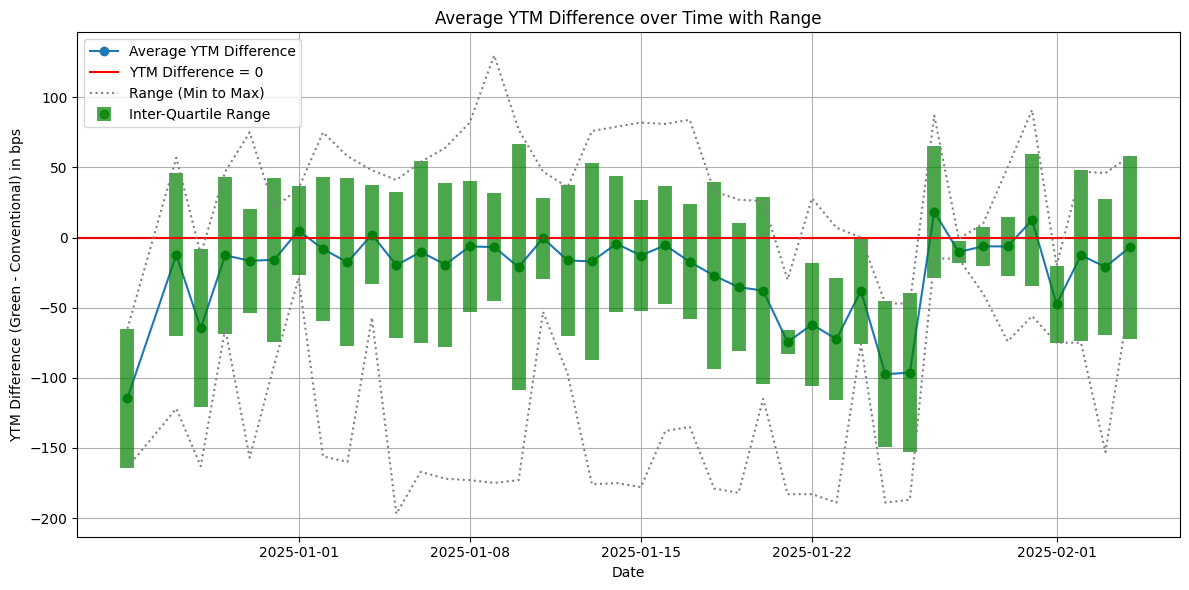

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
# Convert to int64 (nanoseconds since epoch), average, then convert back to datetime
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily averages, extract the date portion (drop the time)
df_matched['pair_date'] = df_matched['pair_date'].dt.date

# Group by the pair_date and calculate the average YTM difference for each day
daily_stats = df_matched.groupby('pair_date').agg(
	mean=('YTM_diff', 'mean'),
	min=('YTM_diff', 'min'),
	max=('YTM_diff', 'max'),
	quant75=('YTM_diff', lambda x: x.quantile(0.75)),
	quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()
iqr = daily_stats['quant75'] - daily_stats['quant25']

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# Create the plot with mean and range
plt.figure(figsize=(12, 6))

# Plot the average line
plt.plot(daily_stats['pair_date'], daily_stats['mean'] * 100, marker='o', linestyle='-', label='Average YTM Difference')

# Plot the range as a boxplot line
plt.errorbar(daily_stats['pair_date'], daily_stats['min'] * 100, linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats['pair_date'], daily_stats['max'] * 100, linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats['pair_date'], daily_stats['mean'] * 100, yerr = iqr * 100, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)

# Adding y = 0
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional) in bps')
plt.title('Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# get list of all dates in the data set
print(daily_stats[daily_stats['pair_date']=='2025-01-25'])
# we order the data by min
daily_stats = daily_stats.sort_values('min')
daily_stats.head()

    pair_date   mean   min   max  quant75  quant25
30 2025-01-25 -0.975 -1.89 -0.47  -0.6125  -1.1325


,pair_date,mean,min,max,quant75,quant25
10,2025-01-05,-0.197391,-1.97,0.41,0.1400,-0.3800
30,2025-01-25,-0.975000,-1.89,-0.47,-0.6125,-1.1325
28,2025-01-23,-0.723333,-1.89,0.07,-0.3700,-0.8075
31,2025-01-26,-0.962500,-1.87,-0.47,-0.5750,-1.1425
27,2025-01-22,-0.620667,-1.83,0.28,-0.3650,-0.8050


We investigate what is causing these extreme values

In [22]:
extreme_dates = daily_stats.head()['pair_date']
print(extreme_dates)

# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# looking at the df we used to calculate the average yields, only looking at the first extreme date: 2025-01-14
# df_matched[df_matched['pair_date'] == extreme_dates.iloc[0]].sort_values('YTM_diff')

# we want to only extract the date from pair_date from the df_matched, it contains the date and time, but we want to match by date only
df_matched['pair_date'] = df_matched['pair_date'].dt.date
df_matched['pair_date'] = pd.to_datetime(df_matched['pair_date'])
df_matched[df_matched['pair_date'] == '2025-01-25'].sort_values('YTM_diff').head()

10   2025-01-05
30   2025-01-25
28   2025-01-23
31   2025-01-26
27   2025-01-22
Name: pair_date, dtype: datetime64[ns]


,Company,Green_Bond_ISIN,Green_Bond_Name,Green_Bond_Coupon,Green_Bond_Maturity,Green_Bond_Emission_Year,Green_Bond_YTM,Green_Bond_Price,Green_Bond_Mdur,Green_Bond_DateTime,...,Conv_Bond_YTM,Conv_Bond_Price,Conv_Bond_Mdur,Conv_Bond_DateTime,Matching_Distance,YTM_diff,Mdur_diff,Coupon_diff,days_to_maturity_diff,pair_date
359,raiffeisen bank international ag,xs2353473692,"Raiffeisen Bank International AG 1,375% 21/33",1.375,3056,2021,2.40,92.22,NaN,2025-02-03 10:01:00+00:00,...,4.29,100.89,NaN,2025-01-16 17:00:00+00:00,3.573818,-1.89,NaN,-3.375,2316,2025-01-25
335,mizuho financial group inc,xs2528323780,"Mizuho Financial Group Inc. 3,49% 22/27",3.490,944,2022,2.71,101.94,2.292,2025-02-03 10:01:00+00:00,...,3.59,90.45,5.253,2025-01-16 17:00:00+00:00,3.122337,-0.88,-2.961,1.394,-1695,2025-01-25
550,caisse francaise de financement local,fr001400dxr9,"Caisse Francaise de Financement Local 3,125% 2...",3.125,1016,2022,2.58,101.46,2.467,2025-02-03 10:01:00+00:00,...,3.24,99.08,5.991,2025-01-16 09:26:00+00:00,3.437942,-0.66,-3.524,0.000,-2218,2025-01-25
334,mizuho financial group inc,xs2672418055,"Mizuho Financial Group Inc. 4,608% 23/30",4.608,2032,2023,3.14,107.54,4.239,2025-02-03 10:01:00+00:00,...,3.61,90.31,5.253,2025-01-16 13:00:00+00:00,3.323706,-0.47,-1.014,2.512,-607,2025-01-25


Before removing the observations of non euro currencies we had problems of bonds denoted in other currencies due to the large differences in yields sometimes present. We see the problem is caused by a bond denominated in turkish lira TRY, from "Instituto de Credito Oficial 29% 24/33" so we drop this one, and repeat the process for other extreme outliers

In [23]:
# I drop the bond from "Instituto de Credito Oficial 29% 24/33" as it is an outlier
#df_matched = df_matched[df_matched['Green_Bond_Name'] != 'Instituto de Credito Oficial 29% 24/33']
# and repeat the same for the other extreme dates: 2025-01-30
# df_matched = df_matched[df_matched['Green_Bond_Name'] != 'International Finance Corp. 11.5% 25/30']
# df_matched = df_matched[df_matched['Green_Bond_Name'] != 'International Finance Corp. 0,000% 20/30']
# df_matched[df_matched['pair_date'] == '2024-12-30'].sort_values('YTM_diff').head()

### Plot average distance measure and number of observations over time

we visualise the amount of observations per date and the mean and weighted mean distance measure over time

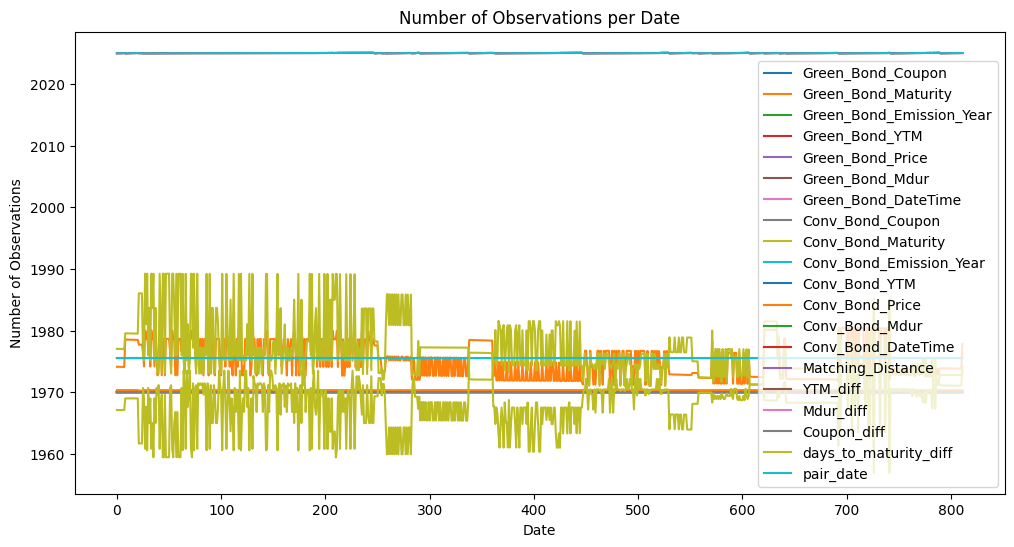

In [24]:
# I want to plot the amount of observations for each date
date_counts = df_matched['pair_date'].value_counts().sort_index()

# I also want to add mean weighted distance measure over time to the plot
date_counts = df_matched.groupby('pair_date')['Matching_Distance'].mean().sort_index()
date_counts = df_matched

plot = date_counts.plot(kind='line', figsize=(12, 6))
plot.set_xlabel('Date')
plot.set_ylabel('Number of Observations')
plot.set_title('Number of Observations per Date')
plt.show()

## Corrected Plot of YTM_Difference over time

To compare we not weight the differences in YTM between green and conventional bonds by the distance measure, more concretely, rescaling them. 
We weight the bond pairs by $ 1 / (1 + MatchingDistance)$ giving a larger weight to bonds that are closer in characteristics.

C:\Users\Alex\AppData\Local\Temp\ipykernel_9172\4092518375.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


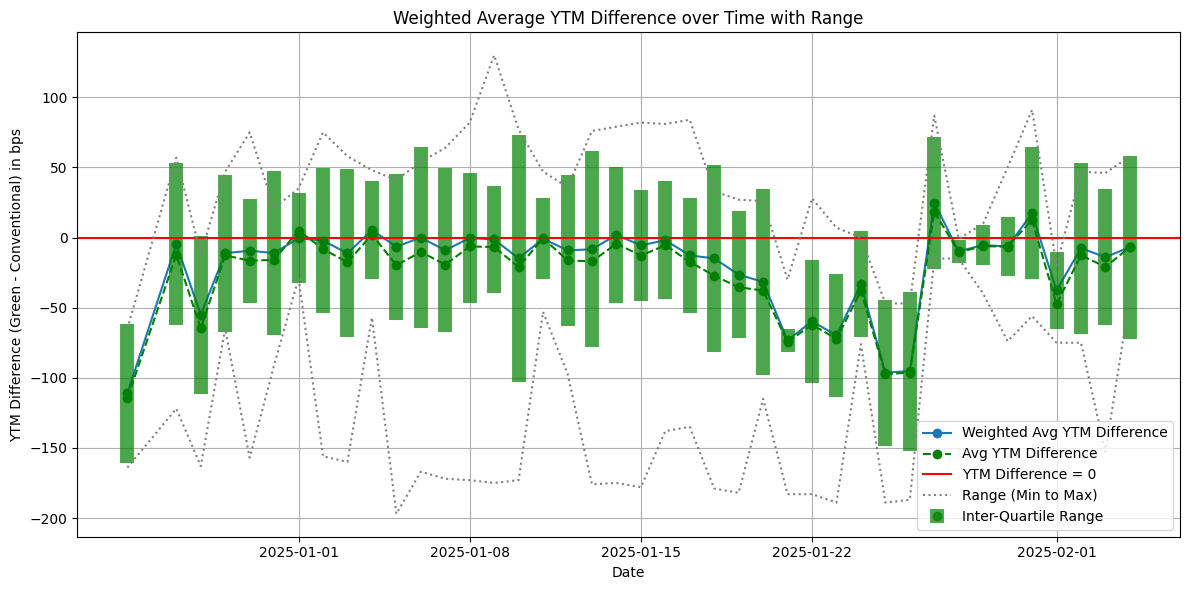

In [25]:
# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily data, drop the time portion
df_matched['pair_date'] = df_matched['pair_date'].dt.date

# ------------------------------------------------------------------------------
#    weight = 1 / (1 + Matching_Distance)
# ------------------------------------------------------------------------------
df_matched['weight'] = 1 / (1 + df_matched['Matching_Distance'])

# ------------------------------------------------------------------------------
# 2) Compute a weighted average YTM_diff for each date
# ------------------------------------------------------------------------------

def weighted_avg(values, weights):
    """Compute the weighted average of 'values' using 'weights'."""
    return np.average(values, weights=weights)

# We also keep track of min and max for a shaded range plot
daily_stats = (
    df_matched
    .groupby('pair_date')
    .apply(lambda group: pd.Series({
        'weighted_mean': weighted_avg(group['YTM_diff'], group['weight']),
        'mean': group['YTM_diff'].mean(),
        'min': group['YTM_diff'].min(),
        'max': group['YTM_diff'].max()
    }))
    .reset_index()
)

quantiles = df_matched.groupby('pair_date').agg(
    quant75=('YTM_diff', lambda x: x.quantile(0.75)), 
    quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()

daily_stats = daily_stats.merge(quantiles, on='pair_date')
iqr = daily_stats['quant75'] - daily_stats['quant25']

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# ------------------------------------------------------------------------------
# 3) Plot the weighted average line along with the min-max range
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

# Weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['weighted_mean'] * 100,
    marker='o', linestyle='-',
    label='Weighted Avg YTM Difference'
)

# Previous non-weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['mean'] * 100,
    marker='o', linestyle='--',
    label='Avg YTM Difference',
    color='green'
)

# Plot the range as a boxplot line
plt.errorbar(daily_stats['pair_date'], daily_stats['min'] * 100, linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats['pair_date'], daily_stats['max'] * 100, linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats['pair_date'], daily_stats['weighted_mean'] * 100, yerr = iqr * 100, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional) in bps')
plt.title('Weighted Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
print(df_matched[['Matching_Distance', 'YTM_diff']].isna().sum())

Matching_Distance    0
YTM_diff             0
dtype: int64


## Winsorising and reformating
I delete the extreme value to have a better look at the dynamics

C:\Users\Alex\AppData\Local\Temp\ipykernel_9172\1113080865.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


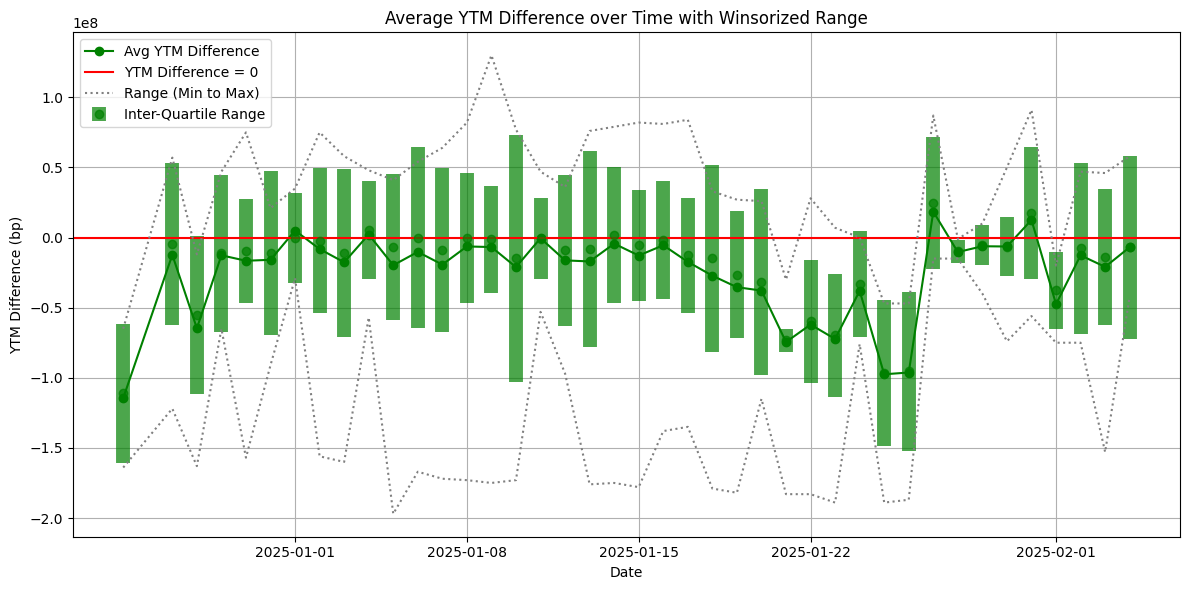

In [29]:
# Ensure the DateTime columns are datetime objects
df_matched['Green_Bond_DateTime'] = pd.to_datetime(df_matched['Green_Bond_DateTime'])
df_matched['Conv_Bond_DateTime'] = pd.to_datetime(df_matched['Conv_Bond_DateTime'])

# Compute a pair date as the midpoint between green and conventional observation times
# Convert to int64 (nanoseconds since epoch), average, then convert back to datetime
df_matched['pair_date'] = pd.to_datetime(
    (df_matched['Green_Bond_DateTime'].astype(np.int64) + df_matched['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# If you prefer daily averages, extract the date portion (drop the time)
df_matched['pair_date'] = df_matched['pair_date'].dt.date

# Convert YTM_diff from percentage to basis points (1% = 100 bp)
df_matched['YTM_diff'] = df_matched['YTM_diff'] * 100

# We also keep track of min and max for a shaded range plot
daily_stats = (
    df_matched
    .groupby('pair_date')
    .apply(lambda group: pd.Series({
        'weighted_mean': weighted_avg(group['YTM_diff'], group['weight']),
        'mean': group['YTM_diff'].mean(),
        'min': group['YTM_diff'].min(),
        'max': group['YTM_diff'].max()
    }))
    .reset_index()
)

quantiles = df_matched.groupby('pair_date').agg(
    quant75=('YTM_diff', lambda x: x.quantile(0.75)), 
    quant25=('YTM_diff', lambda x: x.quantile(0.25))
).reset_index()

daily_stats = daily_stats.merge(quantiles, on='pair_date')
iqr = daily_stats['quant75'] - daily_stats['quant25']

# Convert pair_date back to datetime for plotting
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# Create the plot with mean and the winsorized range
plt.figure(figsize=(12, 6))

# Previous non-weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['mean'] * 100,
    marker='o', linestyle='-',
    label='Avg YTM Difference',
    color='green'
)

# Plot the range as a boxplot line
plt.errorbar(daily_stats['pair_date'], daily_stats['min'] * 100, linestyle=':', color='grey', label='Range (Min to Max)', capsize=5)
plt.errorbar(daily_stats['pair_date'], daily_stats['max'] * 100, linestyle=':', color='grey')
# Add interquartile range (IQR) as a green box around the mean
plt.errorbar(daily_stats['pair_date'], daily_stats['weighted_mean'] * 100, yerr = iqr * 100, color='green', label='Inter-Quartile Range', alpha = 0.7, fmt='o', elinewidth=10, capthick=10)
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')

plt.xlabel('Date')
plt.ylabel('YTM Difference (bp)')
plt.title('Average YTM Difference over Time with Winsorized Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Winzorising does not seem to have a major effect. so maybe not include in paper, only as robustness check.

### One-to-Many Matching
Does this significantly change our results?

In [34]:
def match_green_bonds_one_green_many(df, time_weight=1.0):
    """
    For each issuer (Company), match each green bond observation to every distinct
    conventional bond ISIN, but only to the single time entry that is closest in
    DateTime for that bond.

    This results in multiple matches per green bond (one for each conventional bond),
    but avoids matching the green bond with multiple time observations of the same
    conventional bond.
    """
    # --- Copy data and convert relevant columns to numeric
    df = df.copy()
    df['YTM'] = pd.to_numeric(df['YTM'], errors='coerce')
    df['Coupon'] = pd.to_numeric(df['Coupon'], errors='coerce')
    df['days_to_maturity'] = pd.to_numeric(df['days_to_maturity'], errors='coerce')
    df['Modified Duration'] = pd.to_numeric(df['Modified Duration'], errors='coerce')
    df['Last Price'] = pd.to_numeric(df['Last Price'], errors='coerce')

    # --- Identify emission_year
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    def get_emission_year(row):
        for col in emission_cols:
            if row.get(col) is True:
                # remove potential trailing ".0" and convert to int
                return int(col.split('_')[-1].split('.')[0])
        return np.nan

    df['emission_year'] = df.apply(get_emission_year, axis=1)

    # --- Convert DateTime to numeric (days since epoch)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Time'] = df['DateTime'].astype(np.int64) / (1e9 * 3600 * 24)

    # Sort by DateTime to keep chronological order
    df_sorted = df.sort_values('DateTime')

    matched_results = []

    # --- Loop over each company that has both green and conventional observations
    for company in df_sorted['Company'].unique():
        comp_df = df_sorted[df_sorted['Company'] == company]
        if not (comp_df['is_green'].eq(1).any() and comp_df['is_green'].eq(0).any()):
            continue

        # Split into green and conventional
        green_df = comp_df[comp_df['is_green'] == 1].reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].reset_index(drop=True)

        # Define features for distance calculation
        features = ['Coupon', 'days_to_maturity', 'emission_year', 'Time']

        # Standardize these features across all observations for the company
        combined = comp_df[features]
        means = combined.mean()
        stds = combined.std()

        # Create scaled versions
        green_scaled = (green_df[features] - means) / stds
        conv_scaled = (conv_df[features] - means) / stds

        # Down-weight coupon differences
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight

        # Optionally scale the time feature
        green_scaled['Time'] *= time_weight
        conv_scaled['Time'] *= time_weight

        # Convert scaled DataFrames to numpy arrays
        green_mat = green_scaled.values
        conv_mat = conv_scaled.values

        # Map the original conv_df index to the row in conv_mat
        conv_index_map = {idx: i for i, idx in enumerate(conv_df.index)}

        # --- For each green row, match to each conventional bond ISIN's single closest time
        for g_idx, g_row in green_df.iterrows():
            # We'll create multiple matches for each green bond row:
            # one match per distinct conventional bond ISIN.
            green_time = g_row['Time']
            green_scaled_vec = green_mat[g_idx]  # scaled vector for distance

            for conv_isin in conv_df['ISIN'].unique():
                # Filter to just this ISIN's rows
                subset = conv_df[conv_df['ISIN'] == conv_isin].copy()
                if subset.empty:
                    continue

                # Find the row with the minimal absolute time difference
                subset['abs_time_diff'] = (subset['Time'] - green_time).abs()
                closest_idx = subset['abs_time_diff'].idxmin()
                c_row = subset.loc[closest_idx]

                # Retrieve the scaled vector for that same row
                c_scaled_vec = conv_mat[conv_index_map[closest_idx]]

                # Compute Euclidean distance across scaled features
                dist_val = np.sqrt(((green_scaled_vec - c_scaled_vec) ** 2).sum())

                # Store the match
                matched_results.append({
                    'Company': company,

                    'Green_Bond_ISIN': g_row['ISIN'],
                    'Green_Bond_Name': g_row.get('Name', 'Unknown'),
                    'Green_Bond_Coupon': g_row['Coupon'],
                    'Green_Bond_Maturity': g_row['days_to_maturity'],
                    'Green_Bond_Emission_Year': g_row['emission_year'],
                    'Green_Bond_YTM': g_row['YTM'],
                    'Green_Bond_Price': g_row['Last Price'],
                    'Green_Bond_Mdur': g_row['Modified Duration'],
                    'Green_Bond_DateTime': g_row['DateTime'],

                    'Conv_Bond_ISIN': c_row['ISIN'],
                    'Conv_Bond_Name': c_row.get('Name', 'Unknown'),
                    'Conv_Bond_Coupon': c_row['Coupon'],
                    'Conv_Bond_Maturity': c_row['days_to_maturity'],
                    'Conv_Bond_Emission_Year': c_row['emission_year'],
                    'Conv_Bond_YTM': c_row['YTM'],
                    'Conv_Bond_Price': c_row['Last Price'],
                    'Conv_Bond_Mdur': c_row['Modified Duration'],
                    'Conv_Bond_DateTime': c_row['DateTime'],

                    'Distance': dist_val,
                    'Time_Diff': c_row['abs_time_diff']  # optional
                })

    return pd.DataFrame(matched_results)

In [50]:
df_greedy = match_green_bonds_one_green_many(df_for_matching)
df_greedy

,Company,Green_Bond_ISIN,Green_Bond_Name,Green_Bond_Coupon,Green_Bond_Maturity,Green_Bond_Emission_Year,Green_Bond_YTM,Green_Bond_Price,Green_Bond_Mdur,Green_Bond_DateTime,...,Conv_Bond_Name,Conv_Bond_Coupon,Conv_Bond_Maturity,Conv_Bond_Emission_Year,Conv_Bond_YTM,Conv_Bond_Price,Conv_Bond_Mdur,Conv_Bond_DateTime,Distance,Time_Diff
0,rwe ag,xs2482887879,"RWE AG 2,75% 22/30",2.750,1978,2022,2.92,99.16,4.249,2024-12-23 08:03:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,2.499591,10.225694
1,rwe ag,xs2482887879,"RWE AG 2,75% 22/30",2.750,1974,2022,3.16,97.96,4.249,2024-12-27 09:25:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,2.390110,6.168750
2,rwe ag,xs2412044641,RWE AG 1% 21/33,1.000,3256,2021,3.50,80.74,6.239,2024-12-27 10:29:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,3.596425,6.124306
3,rwe ag,xs2412044567,"RWE AG 0,5% 21/28",0.500,1430,2021,2.82,91.38,3.367,2024-12-27 10:29:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,3.721349,6.124306
4,rwe ag,xs2584685387,"RWE AG 4,125% 23/35",4.125,3700,2023,3.68,103.80,5.988,2024-12-27 10:29:00+00:00,...,"RWE AG 3,625% 24/32",3.625,2564,2024,3.21,102.61,5.000,2025-01-02 13:28:00+00:00,1.570557,6.124306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2849,2021,2.20,94.06,NaN,2025-02-03 16:20:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.600120,20.106944
16924,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2848,2021,2.21,94.02,NaN,2025-02-04 08:47:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.605453,20.792361
16925,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2848,2021,2.21,94.03,NaN,2025-02-04 10:47:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.606574,20.875694
16926,bayerische landesbank,xs2411178630,"Bayerische Landesbank 1,375% 21/32",1.375,2848,2021,2.21,94.03,NaN,2025-02-04 14:47:00+00:00,...,"Bayerische Landesbank 2,875% 24/28",2.875,1399,2024,2.61,100.95,3.269,2025-01-14 13:46:00+00:00,12.608829,21.042361


In [51]:
# Create a new column for the YTM difference (green bond YTM minus conventional bond YTM)
df_greedy['YTM_diff'] = df_greedy['Green_Bond_YTM'] - df_greedy['Conv_Bond_YTM']
df_greedy['Mdur_diff'] = df_greedy['Green_Bond_Mdur'] - df_greedy['Conv_Bond_Mdur']
df_greedy['Coupon_diff'] = df_greedy['Green_Bond_Coupon'] - df_greedy['Conv_Bond_Coupon']
df_greedy['days_to_maturity_diff'] = df_greedy['Green_Bond_Maturity'] - df_greedy['Conv_Bond_Maturity']
print(df_greedy.head())
print(df_greedy['YTM_diff'].describe())

  Company Green_Bond_ISIN      Green_Bond_Name  Green_Bond_Coupon  \
0  rwe ag    xs2482887879   RWE AG 2,75% 22/30              2.750   
1  rwe ag    xs2482887879   RWE AG 2,75% 22/30              2.750   
2  rwe ag    xs2412044641      RWE AG 1% 21/33              1.000   
3  rwe ag    xs2412044567    RWE AG 0,5% 21/28              0.500   
4  rwe ag    xs2584685387  RWE AG 4,125% 23/35              4.125   

   Green_Bond_Maturity  Green_Bond_Emission_Year  Green_Bond_YTM  \
0                 1978                      2022            2.92   
1                 1974                      2022            3.16   
2                 3256                      2021            3.50   
3                 1430                      2021            2.82   
4                 3700                      2023            3.68   

   Green_Bond_Price  Green_Bond_Mdur       Green_Bond_DateTime  ...  \
0             99.16            4.249 2024-12-23 08:03:00+00:00  ...   
1             97.96            4.2

C:\Users\Alex\AppData\Local\Temp\ipykernel_9172\3272853332.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


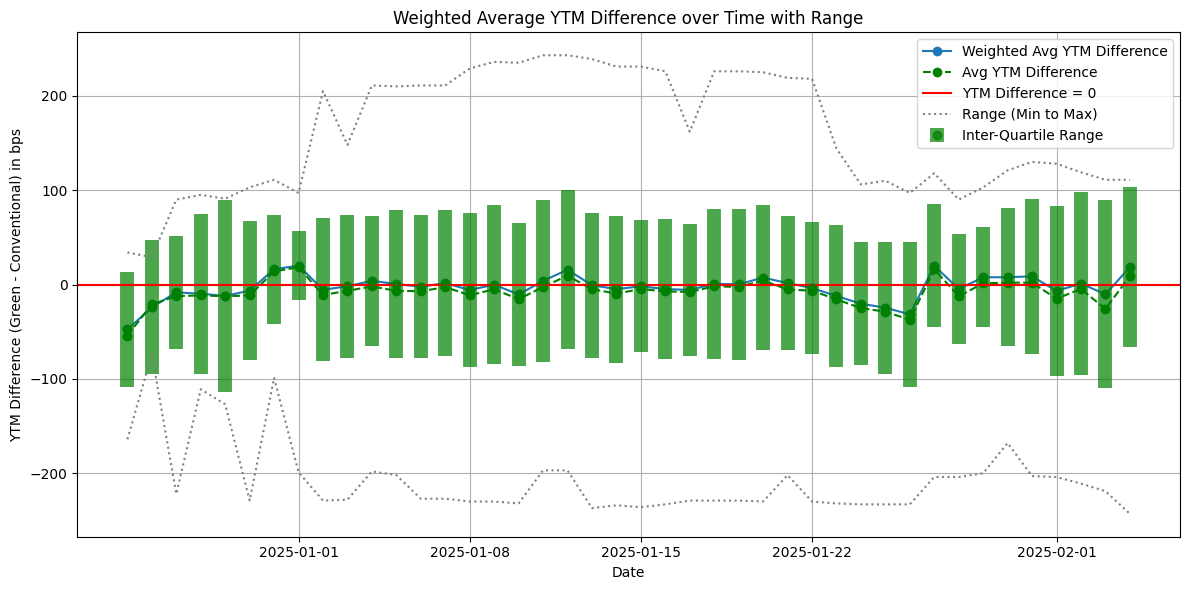

In [52]:
# 1. Convert the DateTime columns to actual datetime objects
df_greedy['Green_Bond_DateTime'] = pd.to_datetime(df_greedy['Green_Bond_DateTime'])
df_greedy['Conv_Bond_DateTime'] = pd.to_datetime(df_greedy['Conv_Bond_DateTime'])

# 2. Compute a midpoint 'pair_date' between green and conventional bond DateTime
df_greedy['pair_date'] = pd.to_datetime(
    (df_greedy['Green_Bond_DateTime'].astype(np.int64) + df_greedy['Conv_Bond_DateTime'].astype(np.int64)) // 2
)

# 3. If you prefer daily data (no time component), extract just the date
df_greedy['pair_date'] = df_greedy['pair_date'].dt.date

# 4. Create a weight based on the distance
df_greedy['weight'] = 1 / (1 + df_greedy['Distance'])

# 5. Define a helper function for weighted averages
def weighted_avg(values, weights):
    """Compute the weighted average of 'values' using 'weights'."""
    return np.average(values, weights=weights)

# 6. Group by date and compute statistics
daily_stats = (
    df_greedy
    .groupby('pair_date')
    .apply(lambda group: pd.Series({
        'weighted_mean': weighted_avg(group['YTM_diff'], group['weight']),
        'mean': group['YTM_diff'].mean(),
        'min': group['YTM_diff'].min(),
        'max': group['YTM_diff'].max()
    }))
    .reset_index()
)

# 7. Calculate the 25th and 75th percentiles for IQR
quantiles = (
    df_greedy
    .groupby('pair_date')
    .agg(
        quant75=('YTM_diff', lambda x: x.quantile(0.75)),
        quant25=('YTM_diff', lambda x: x.quantile(0.25))
    )
    .reset_index()
)

# 8. Merge percentile data into daily_stats
daily_stats = daily_stats.merge(quantiles, on='pair_date', how='left')
iqr = daily_stats['quant75'] - daily_stats['quant25']

# 9. Convert pair_date back to datetime (optional for plotting)
daily_stats['pair_date'] = pd.to_datetime(daily_stats['pair_date'])

# 10. Plot the results
plt.figure(figsize=(12, 6))

# Weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['weighted_mean'] * 100,   # convert to basis points
    marker='o',
    linestyle='-',
    label='Weighted Avg YTM Difference'
)

# Non-weighted average line
plt.plot(
    daily_stats['pair_date'],
    daily_stats['mean'] * 100,            # convert to basis points
    marker='o',
    linestyle='--',
    color='green',
    label='Avg YTM Difference'
)

# Plot the min-max range as “error bars”
plt.errorbar(
    daily_stats['pair_date'],
    daily_stats['min'] * 100,
    linestyle=':',
    color='grey',
    label='Range (Min to Max)',
    capsize=5
)
plt.errorbar(
    daily_stats['pair_date'],
    daily_stats['max'] * 100,
    linestyle=':',
    color='grey'
)

# Plot the IQR around the weighted mean
plt.errorbar(
    daily_stats['pair_date'],
    daily_stats['weighted_mean'] * 100,
    yerr=iqr * 100,
    color='green',
    label='Inter-Quartile Range',
    alpha=0.7,
    fmt='o',
    elinewidth=10,
    capthick=10
)

# Horizontal line at zero difference
plt.axhline(y=0, color='r', linestyle='-', label='YTM Difference = 0')

plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional) in bps')
plt.title('Weighted Average YTM Difference over Time with Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The one-to-many matching method produces results that are much more centered around 0. presumambly because we use similar bonds much more often in the analysis

# Addtional Regressions on one-to-many dataframe

\noindent In addition to the matching method, we re‐estimate the panel regression with issuer‐level fixed effects to account for the unobserved heterogeneity present in our data set, and address time‐series dependence by using Newey–West derived standard errors. We also cluster standard errors at the issuer level, since price data within each issuer are likely to be correlated. By including issuer fixed effects, we control for all time‐invariant, issuer‐specific attributes, thereby mitigating concerns arising from missing credit‐rating data. Moreover, clustering the standard errors at the issuer level helps address potential serial correlation over time within each issuer’s series.

\subsection{Conceptual Setup}

A simplified version of the panel model can be written as:
\begin{equation}
\mathrm{YTM}_{i,t} \;=\; \alpha_i \;+\; \gamma_t \;+\; \beta \,\mathrm{GreenIndicator}_{i,t}
\;+\; X_{i,t}\,\delta \;+\; \varepsilon_{i,t},
\end{equation}
where \(i\) indexes issuers (or bonds), \(t\) indexes time (e.g.\ day, week, or month), \(\alpha_i\) denotes issuer fixed effects capturing all unobserved time‐invariant heterogeneity at the issuer level, \(\gamma_t\) is a time fixed effect (often included if there is a desire to remove common time shocks), \(\mathrm{GreenIndicator}_{i,t}\) is a dummy variable taking the value of 1 if the bond is green at time \(t\) and 0 otherwise, \(X_{i,t}\) represents a vector of additional controls (for instance, days to maturity, coupon, or modified duration), \(\beta\) is the coefficient of interest measuring the average difference in yield between green and conventional bonds conditional on the included controls, and \(\varepsilon_{i,t}\) is the error term clustered by issuer \(i\) to address serial correlation and heteroscedasticity.


In [67]:
print(df_for_matching.head())
print(df_for_matching.columns)

                   Name Clean_Company_Maturity     WKN  \
0  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   
1  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   
2  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   
3  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   
4  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   

                                                 URL          ISIN  Company  \
0  https://www.boerse-frankfurt.de/anleihe/xs2103...  xs2103014291  e on se   
1  https://www.boerse-frankfurt.de/anleihe/xs2103...  xs2103014291  e on se   
2  https://www.boerse-frankfurt.de/anleihe/xs2103...  xs2103014291  e on se   
3  https://www.boerse-frankfurt.de/anleihe/xs2103...  xs2103014291  e on se   
4  https://www.boerse-frankfurt.de/anleihe/xs2103...  xs2103014291  e on se   

  Kupon_Maturity  Coupon  Maturity_Start  Maturity_End  ...  \
0    0 375 20 27   0.375              20            27  ...   
1    0 375 20 27   0.375              20          

In [73]:
from linearmodels import PanelOLS

# 2. Parse the 'Date' column (DD/MM/YYYY format) as datetime
df_for_matching['Date'] = pd.to_datetime(df_for_matching['Date'], format='%d/%m/%Y', errors='coerce')

# 3. Convert 'days_to_maturity' (and any other relevant numeric columns) to numeric
df_for_matching['days_to_maturity'] = pd.to_numeric(df_for_matching['days_to_maturity'], errors='coerce')
df_for_matching['Coupon'] = pd.to_numeric(df_for_matching['Coupon'], errors='coerce')
df_for_matching['YTM'] = pd.to_numeric(df_for_matching['YTM'], errors='coerce')
df_for_matching['Modified Duration'] = pd.to_numeric(df_for_matching['Modified Duration'], errors='coerce')
df_for_matching.rename(columns={'Modified Duration': 'Modified_Duration'}, inplace=True)

# Create a multi-index with (Company, Date)
df_panel = df_for_matching.set_index(['Company', 'Date'])
model_panel = PanelOLS.from_formula(
    formula="YTM ~ days_to_maturity + Modified_Duration + Coupon + is_green + EntityEffects",
    data=df_panel
)

# Fit the model, clustering standard errors by issuer (the entity)
results_panel = model_panel.fit(cov_type='clustered', cluster_entity=True)
print(results_panel.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    YTM   R-squared:                        0.5704
Estimator:                   PanelOLS   R-squared (Between):              0.3120
No. Observations:                5445   R-squared (Within):               0.5704
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.3358
Time:                        18:17:04   Log-likelihood                    941.30
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1795.1
Entities:                          32   P-value                           0.0000
Avg Obs:                       170.16   Distribution:                  F(4,5409)
Min Obs:                       1.0000                                           
Max Obs:                       797.00   F-statistic (robust):             29.590
                            

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


# To-Do: Create comparision table